# NIFTY 50 Financial Analytics Case Study  
## 03 - Predictive Modeling  

This notebook develops classification models to predict next-day market direction.

The modeling framework:

- Uses time-based train-test split
- Compares against naive baseline
- Applies scaling where required
- Evaluates model generalization
- Provides financial interpretation

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [38]:
df = pd.read_csv("../data/nifty50_features.csv")

df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date")
df.reset_index(drop=True, inplace=True)

df.head()

,Date,Close,High,Low,Open,Volume,Log_Return,SMA_10,SMA_20,SMA_50,EMA_10,Volatility_10,Volatility_20,RSI,Return_Lag1,Return_Lag2,Return_Lag3,Volume_Change,Volume_SMA_10,Target
0,2013-01-21,6082.299805,6094.350098,6065.100098,6085.750000,130900.0,0.002947,6016.154980,5973.07251,5857.329990,6024.030449,0.006133,0.006739,69.999945,0.004164,0.006204,-0.009081,inf,13090.0,0
1,2013-01-22,6048.500000,6101.299805,6040.500000,6080.149902,129000.0,-0.005573,6020.834961,5983.11250,5863.811992,6028.479458,0.006522,0.006236,57.107931,0.002947,0.004164,0.006204,-0.014515,25990.0,1
2,2013-01-23,6054.299805,6069.799805,6021.149902,6052.850098,137000.0,0.000958,6029.114941,5993.03999,5869.695986,6033.174067,0.006195,0.006238,55.922763,-0.005573,0.002947,0.004164,0.062016,39690.0,0
3,2013-01-24,6019.350098,6065.299805,6007.850098,6046.200195,185200.0,-0.005789,6034.184961,5998.72749,5875.307988,6030.660618,0.006587,0.006234,50.393628,0.000958,-0.005573,0.002947,0.351825,58210.0,1
4,2013-01-25,6074.649902,6080.549805,6014.450195,6024.500000,147600.0,0.009145,6046.519971,6008.95498,5883.075986,6038.658669,0.006918,0.006262,59.935496,-0.005789,0.000958,-0.005573,-0.203024,72970.0,1


In [39]:
print("Target Distribution:")
print(df["Target"].value_counts())
print("\nProportion:")
print(df["Target"].value_counts(normalize=True))

Target Distribution:
Target
1    1704
0    1475
Name: count, dtype: int64

Proportion:
Target
1    0.536018
0    0.463982
Name: proportion, dtype: float64


### Class Balance Analysis

If the dataset contains more upward days than downward days, 
a naive classifier predicting the majority class could achieve reasonable accuracy.

Therefore, model performance must be compared against a baseline.

In [40]:
# Feature / Target separation (numeric only)
X = df.select_dtypes(include=[np.number]).drop("Target", axis=1)
y = df["Target"]

# Replace infinite values with NaN
X = X.replace([np.inf, -np.inf], np.nan)

# Drop rows that became NaN
df_model = pd.concat([X, y], axis=1).dropna()

X = df_model.drop("Target", axis=1)
y = df_model["Target"]

In [41]:
split_index = int(len(df_model) * 0.8)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))

Training set size: 2522
Testing set size: 631


### Time-Series Split

A chronological split is used instead of random sampling.

This preserves temporal structure and prevents future information leakage.

In [42]:
# Baseline: Always predict majority class from training set
majority_class = y_train.mode()[0]
baseline_pred = [majority_class] * len(y_test)

baseline_accuracy = accuracy_score(y_test, baseline_pred)

print("Baseline Accuracy:", baseline_accuracy)

Baseline Accuracy: 0.5435816164817749


### Baseline Interpretation

The predictive models must outperform this naive baseline 
to demonstrate meaningful predictive power.

In [43]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Scaling

Logistic Regression requires scaling for optimal convergence.

Tree-based models such as Random Forest are scale-invariant.

### Logistic Regression

Chosen because:

- Interpretable coefficients
- Suitable for binary classification
- Produces probability estimates

In [44]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train)

log_train_acc = log_model.score(X_train_scaled, y_train)
log_test_acc = log_model.score(X_test_scaled, y_test)

print("Logistic Regression Train Accuracy:", log_train_acc)
print("Logistic Regression Test Accuracy:", log_test_acc)

Logistic Regression Train Accuracy: 0.5479777954004759
Logistic Regression Test Accuracy: 0.5324881141045958


Logistic Regression performs similarly to the baseline, 
suggesting that linear relationships among engineered features 
provide limited additional predictive power.

### Random Forest

Chosen because:

- Captures nonlinear relationships
- Handles feature interactions
- Robust to multicollinearity

In [45]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

rf_train_acc = rf_model.score(X_train, y_train)
rf_test_acc = rf_model.score(X_test, y_test)

print("Random Forest Train Accuracy:", rf_train_acc)
print("Random Forest Test Accuracy:", rf_test_acc)

Random Forest Train Accuracy: 1.0
Random Forest Test Accuracy: 0.48335974643423135


In [46]:
comparison_df = pd.DataFrame({
    "Model": ["Baseline", "Logistic Regression", "Random Forest"],
    "Test Accuracy": [baseline_accuracy, log_test_acc, rf_test_acc]
})

comparison_df

,Model,Test Accuracy
0,Baseline,0.543582
1,Logistic Regression,0.532488
2,Random Forest,0.483360


## Overfitting Analysis

Logistic Regression shows training accuracy of approximately 0.55
and test accuracy of approximately 0.53

The gap between training and test performance is relatively small, 
suggesting limited overfitting.

Random Forest shows training accuracy of approximately 1 
and test accuracy of approximately 0.48

The larger gap between training and testing accuracy indicates that 
Random Forest may be overfitting noise in the financial time series.

Financial markets are highly noisy and nonlinear ensemble models 
can easily fit random fluctuations that do not generalize out-of-sample.

In [47]:
from sklearn.metrics import classification_report

print("----- Logistic Regression Classification Report -----")
print(classification_report(y_test, log_model.predict(X_test_scaled)))

print("----- Random Forest Classification Report -----")
print(classification_report(y_test, rf_model.predict(X_test)))

----- Logistic Regression Classification Report -----
              precision    recall  f1-score   support

           0       0.49      0.50      0.50       288
           1       0.57      0.56      0.56       343

    accuracy                           0.53       631
   macro avg       0.53      0.53      0.53       631
weighted avg       0.53      0.53      0.53       631

----- Random Forest Classification Report -----
              precision    recall  f1-score   support

           0       0.47      0.93      0.62       288
           1       0.65      0.10      0.18       343

    accuracy                           0.48       631
   macro avg       0.56      0.52      0.40       631
weighted avg       0.57      0.48      0.38       631



In [48]:
from sklearn.metrics import classification_report, roc_auc_score

# Logistic
log_probs = log_model.predict_proba(X_test_scaled)[:,1]
log_auc = roc_auc_score(y_test, log_probs)

print("Logistic AUC:", log_auc)

# Random Forest
rf_probs = rf_model.predict_proba(X_test)[:,1]
rf_auc = roc_auc_score(y_test, rf_probs)

print("Random Forest AUC:", rf_auc)

Logistic AUC: 0.5431142695173308
Random Forest AUC: 0.5045553935860059


Both models produce AUC values close to 0.5, 
indicating weak ranking ability consistent with near-random behavior.

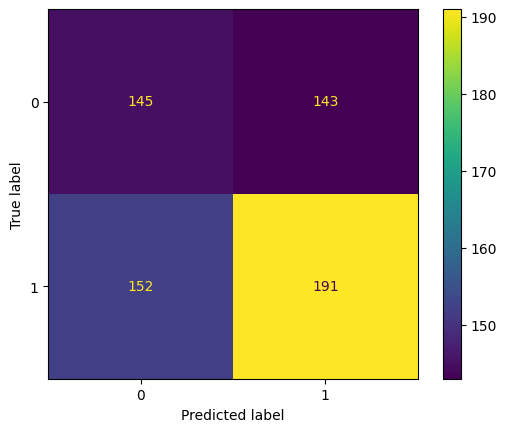

In [49]:
from sklearn.metrics import ConfusionMatrixDisplay

best_model = rf_model if rf_test_acc > log_test_acc else log_model
X_test_used = X_test if best_model == rf_model else X_test_scaled

ConfusionMatrixDisplay.from_estimator(best_model, X_test_used, y_test)
plt.show()

In [50]:
import pandas as pd

feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importance = feature_importance.sort_values(ascending=False)

feature_importance.head(10)

Log_Return       0.081568
Return_Lag2      0.070284
Return_Lag3      0.067575
Return_Lag1      0.066646
RSI              0.066590
Volume_Change    0.065268
Volatility_20    0.063964
Volatility_10    0.063325
Volume           0.061044
Volume_SMA_10    0.060479
dtype: float64

### Feature Importance Analysis

Random Forest feature importance indicates which variables 
contribute most to prediction.

This helps identify whether:

- Momentum features dominate
- Volatility measures matter
- Lag returns contain signal

Such analysis provides financial insight beyond pure prediction accuracy.

## Economic Interpretation

Even modest predictive accuracy (e.g., 55–60%) may be economically meaningful
if it translates into profitable trading signals.

However, predictive accuracy alone does not guarantee profitability.

The next notebook evaluates financial performance through
strategy returns and risk-adjusted metrics.

## Market Efficiency Interpretation

The inability of models to consistently outperform the baseline 
suggests that daily NIFTY 50 movements exhibit characteristics 
consistent with weak-form market efficiency.

Short-term price movements contain limited exploitable predictive structure.

This result aligns with empirical financial literature, 
which shows that daily index-level prediction is challenging.

While predictive accuracy is modest, financial viability must be assessed 
through strategy-level backtesting, which is addressed in the next notebook.

In [53]:
# ------------------------------------------
# Final Model Selection (Logistic Regression)
# ------------------------------------------

selected_model_name = "Logistic Regression"

# Get test indices
test_indices = df_model.index[split_index:]

# Extract actual log returns from df_model
actual_returns = df_model.loc[test_indices, "Log_Return"]

# Save test predictions for evaluation
evaluation_df = pd.DataFrame({
    "Date": df.loc[test_indices, "Date"].values,
    "Actual_Return": actual_returns.values,
    "Prediction": log_model.predict(X_test_scaled)
})

evaluation_df.to_csv("../data/evaluation_data.csv", index=False)

print("Selected Model:", selected_model_name)
print("Evaluation data saved successfully.")

Selected Model: Logistic Regression
Evaluation data saved successfully.


## Final Model Selection

Based on stability and generalization performance,
Logistic Regression is selected for financial evaluation.

Random Forest exhibited signs of overfitting,
while Logistic Regression demonstrated more stable out-of-sample behavior.